# Dynamic Time Warping

In [ ]:
# Install yfinance package. 
!pip install yfinance 
!pip install fastdtw

In [1]:
import yfinance as yf 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
# constants
today = '2022-01-01'
ticker_dct = {
    'SHOP' : ['2015-05-22',today],
    'COIN' : ['2021-04-16',today],
    'DOCN' : ['2021-03-26',today],
    'BMBL' : ['2021-02-12',today],
    'COUR' : ['2021-04-01',today],
    'DUOL' : ['2021-07-30',today]
}

## Import Data

In [3]:
def fetch_stock_data(ticker_dct):
    '''
    This function will fetch stock data through the yahoo finance
    stock api.
    The ticker_dct will be of the following format : 
        - Key -> Ticker 
        - Values -> Start date, end date of the stock data
    
    params:
        ticker_dct (Dictionary) : The stocks you want to fetch the data for
        
    returns:
        This funciton will return a dictionary, the key will be the ticker
        and the value will be the data associated to that ticker over the
        specified user time period
    '''
    
    for k,v in ticker_dct.items():
        ticker_dct[k] = yf.download(k, v[0], v[1])
    return ticker_dct

In [4]:
dfs = fetch_stock_data(ticker_dct)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Visualize Trend Lines

In [5]:
def visualize_close_prices(dfs):
    '''
    This function will visualize the closing prices associated
    to a given input dataframe
    '''
    for k,v in dfs.items():
        plt.title(k)
        v.Close.plot()
        plt.show()

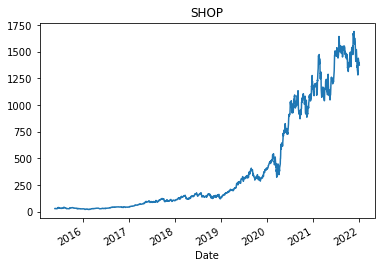

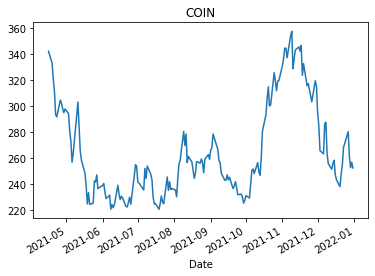

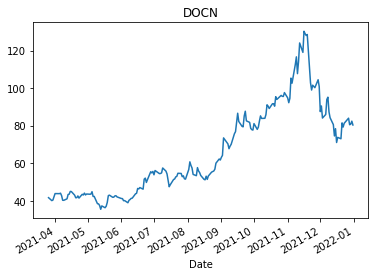

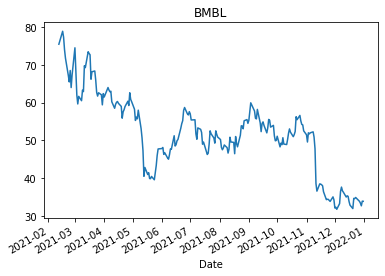

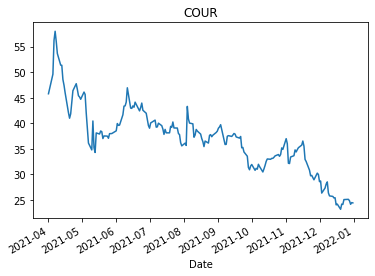

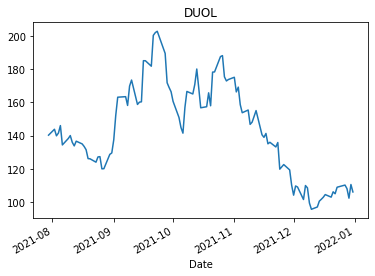

In [6]:
visualize_close_prices(dfs)

## Find Stocks Similar to Shopify

In [23]:
# benchmark the dates to start from 0
for ticker, df in dfs.items():
    dates = df.index.values
    date_map = {date:idx for idx, date in enumerate(dates)}
    
    dfs[ticker]['benchmark_date'] = dfs[ticker].index.map(date_map)

In [29]:
# identify the minimum date difference available to conduct time series analysis on
days_diff = {
    k:df.benchmark_date.max() - df.benchmark_date.min() for k,df in dfs.items()
}
max_range = min(days_diff.values())

In [30]:
# update dfs to be between 0 and max_range
dfs = {k:df[df['benchmark_date'].between(0, max_range)] for k,df in dfs.items()}

In [31]:
benchmark = np.array(dfs['SHOP'].Close.values)

In [32]:
distances = {}
for k,v in dfs.items():
    if k != 'SHOP':
        y = np.array(v.Close.values)
        d,p = fastdtw(benchmark, y)
        distances[k] = d

In [33]:
distances

{'COIN': 23817.540073394775,
 'DOCN': 1551.9699783325195,
 'BMBL': 2700.2300148010254,
 'COUR': 802.4999809265137,
 'DUOL': 12059.039966583252}

These are the distances between the stock trend associated to recent IPO companies in comparison to Shopify during the same initial time period that they've been public. How you can interpret the result is quite simple, the values in the distances dictionary correspond to the distance from the trend observed by Shopify and the trend observed by the startup (aka the key in distances dictionary). The lower the value implies the more similar the trend lines are and the higher the value implies the more different the trend lines. Clearly we can see COUR (aka Course Era) holds the most similar trend line to Shopify, however just because it's the most similar, doesn't imply it will have the same level of success as Shopify did. It's quite hard to gauge it and although COUR is the most similar in this selection of data, it's still quite far from the Shopify trend line. 

## Implement DTW

In [5]:
def dtw(x,y):
    '''
    This function will calculate the cost matrix of two time series using the
    DTW formulation.
    
    params:
        x (Numpy Array) : The first time series
        y (Numpy Array) : The second time series
        
    returns:
        The cost matrix associated to the two time series.
        
    example:
        x = np.array([0,2,0,1,0, -1, 1])
        y = np.array([0,1,-1,-0,2,-1,0])
        dtw(x,y)
    '''
    n, m = len(x), len(y)
    
    # generate & initialize cost matrix
    cost_mat = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            if i == 0 and j == 0:
                cost_mat[i,j] = 0
            else:
                cost_mat[i,j] = np.inf

    # Fill the cost matrix 
    for i in range(1, n+1):
        for j in range(1, m+1):
            c = abs(x[i-1] - y[j-1])
            _min = min([cost_mat[i-1,j-1], cost_mat[i-1,j], cost_mat[i, j-1]])
            cost_mat[i,j] = c + _min
    return cost_mat    

In [7]:
x = np.array([0.5, 21, 34, 5, 2, 4, 2, 0])
y = np.array([5, 42, 23, 4, 2, 4, 5, 3, 2, 1, 30, 0,0])
res = dtw(x,y)